#Import Packages

In [1]:
pip install scikit-plot

In [0]:
import pandas as pd
import numpy as np

# Training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Models
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

# Visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import scikitplot as skplt
import itertools
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Load Dataset

In [6]:
from google.colab import files
uploaded = files.upload()

Saving generated_reviews (train).txt to generated_reviews (train).txt
Saving processed_fine_tuned_reviews.txt to processed_fine_tuned_reviews.txt
Saving processed_gpt2_medium_reviews.txt to processed_gpt2_medium_reviews.txt
Saving processed_human_reviews.txt to processed_human_reviews.txt
Saving processed_reviews_talk_to_transformer.txt to processed_reviews_talk_to_transformer.txt


In [0]:
def load_dataset():
  df_t2t = pd.read_csv('processed_reviews_talk_to_transformer.txt', sep="\n", header=None, names=['Review'])
  df_gpt2Medium = pd.read_csv('processed_gpt2_medium_reviews.txt', sep="\n", header=None, names=['Review'])
  df_fineTuned = pd.read_csv('processed_fine_tuned_reviews.txt', sep="\n", header=None, names=['Review'])
  df_human = pd.read_csv('processed_human_reviews.txt', sep="\n", header=None, names=['Review'])
  df_generated_reviews = pd.read_csv('generated_reviews (train).txt', sep="\n", header=None, names=['Review'])
  df_t2t['Label'] = 1
  df_gpt2Medium['Label'] = 1
  df_fineTuned['Label'] = 1
  df_generated_reviews['Label'] = 1
  df_human['Label'] = 0
  return df_t2t, df_gpt2Medium, df_fineTuned, df_human, df_generated_reviews

In [0]:
(df_t2t, df_gpt2Medium, df_fineTuned, df_human, df_generated_reviews) = load_dataset()

In [0]:
# print(df_t2t.head(10))
# print(df_gpt2Medium.head(10))
# print(df_fineTuned.head(10))
# print(df_human.head(10))
# df_generated_reviews.head()

In [0]:
# print(df_t2t.nunique())
# print(df_gpt2Medium.nunique())
# print(df_fineTuned.nunique())
# print(df_human.nunique())

In [0]:
def combine_datasets():
  frames = [df_t2t, df_gpt2Medium, df_fineTuned, df_human]
  result = pd.concat(frames)
  return result

In [0]:
df_Reviews = combine_datasets()
df_Reviews = df_Reviews.sample(frac=1).reset_index(drop=True) # shuffle rows in place

In [13]:
df_Reviews.head()

,Review,Label
0,David Frum has written a brilliant and very re...,1
1,"<div id=""video-block-R35Y1BCJHWT6RA"" class=""a-...",1
2,"I read the reviews posted by other buyers, so ...",0
3,"For the price, this is perfectly acceptable. ...",1
4,"I'm not one to leave reviews, but I must leave...",0


In [14]:
df_Reviews.nunique()

Review    12619
Label         2
dtype: int64

#Extract Training & Test Sets

In [0]:
# Split dataset into training and test sets
train, test = train_test_split(df_Reviews, test_size = 0.2, random_state = 2)
x_train = train['Review']
y_train = train['Label']
x_test = test['Review']
y_test = test['Label']

In [16]:
x_test.head(5)

5143    <div id="video-block-R2832BRTS25V9D" class="a-...
5985    I have to admit to the same technical difficul...
5027    I love puzzle games.  I love the Search and Fi...
9662    Thank you to the many reviewers before me ... ...
8793    I remember one day I was in school and one of ...
Name: Review, dtype: object

In [17]:
y_test.head(5)

5143    0
5985    0
5027    0
9662    0
8793    1
Name: Label, dtype: int64

#Dummy Classifier

In [0]:
dummy_clf_stratified = DummyClassifier(strategy="stratified")
dummy_clf_uniform = DummyClassifier(strategy="uniform")
model_dummyStratified = dummy_clf_stratified.fit(x_train, y_train)
model_dummyUniform = dummy_clf_uniform.fit(x_train, y_train)

# Naive Bayes Model

In [0]:
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])
model_NaiveBayes = text_clf.fit(x_train, y_train)

#Linear SVC

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1467
           1       0.81      0.80      0.80      1062

    accuracy                           0.84      2529
   macro avg       0.83      0.83      0.83      2529
weighted avg       0.84      0.84      0.84      2529

SVC  Accuracy: 0.8366943455911428
SVC  True Positive Rate: 0.7975517890772128
SVC  True Negative Rate: 0.8650306748466258
SVC  F1-score: 0.8039867109634552

Confusion matrix, without normalization
[[1269  198]
 [ 215  847]]


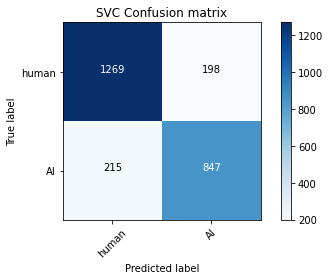

ROC can't be generated for SVC 
-----------------------------------------------------



In [35]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),])

model_linearSVC = text_clf.fit(x_train, y_train)
predicted = text_clf.predict(x_test)
print(metrics.classification_report(y_test, predicted))
stats("SVC ", model_linearSVC, x_test, y_test)

#Stochastic Gradient Descent Classifier

In [0]:
def trainSVM():
  penaltyList = ['l1', 'l2']
  lossList = ['perceptron', 'squared_epsilon_insensitive', 'modified_huber', 'squared_hinge', 'hinge']
  alphaList = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

  f1Score = np.array([])# Array to store Misclassification Error
  penalty = np.array([]) # Array to store regularization function
  lossFxn = np.array([]) # Array to store loss function 
  alpha = np.array([]) # Array to alpha values

  for p in penaltyList:
    for a in alphaList:
      cv_method = KFold(n_splits=5,shuffle=True) #Define CV method
      for l in lossList:
        penalty = np.append(penalty, p)
        lossFxn = np.append(lossFxn, l)
        alpha = np.append(alpha, a)

        text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss= l, penalty = p, 
                                            alpha=a, max_iter=1000, random_state=7))])
        error = np.mean(cross_val_score(text_clf,x_train,y_train,cv = cv_method,scoring = 'roc_auc')) #Run cross validation
        f1Score = np.append(f1Score, error)

  return (penalty, lossFxn, alpha, f1Score)

In [27]:
(penalty, lossFxn, alpha, f1Score) = trainSVM()

KeyboardInterrupt: ignored

In [0]:
def concatSVMResults(alpha, penalty, lossFxn, f1Score):
  df_penalty = pd.DataFrame(penalty)
  df_penalty.columns = ['Regulization']

  df_lossFxn = pd.DataFrame(lossFxn)
  df_lossFxn.columns = ['Loss Function']

  df_f1Score = pd.DataFrame(f1Score)
  df_f1Score.columns = ['roc_auc']

  df_alpha = pd.DataFrame(alpha)
  df_alpha.columns = ['alpha']

  # Concatenate all the dataframes
  df1 = pd.concat([df_penalty, df_lossFxn.reindex(df_penalty.index)], axis=1)
  df2 = pd.concat([df1, df_alpha.reindex(df1.index)], axis=1)
  df_SVM = pd.concat([df2, df_f1Score.reindex(df2.index)], axis=1)

  # Sort values
  df_SVM = df_SVM.sort_values(by=['roc_auc'], ascending=False).reset_index(drop=True)

  return df_SVM

In [0]:
df_SVM = concatSVMResults(alpha, penalty, lossFxn, f1Score)
df_SVM.head(10)

SGDC  Accuracy: 0.8291814946619217
SGDC  True Positive Rate: 0.8239171374764596
SGDC  True Negative Rate: 0.8329925017041582
SGDC  F1-score: 0.8020164986251146

Confusion matrix, without normalization
[[1222  245]
 [ 187  875]]


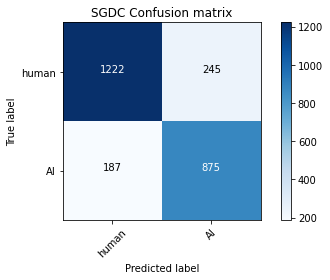

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


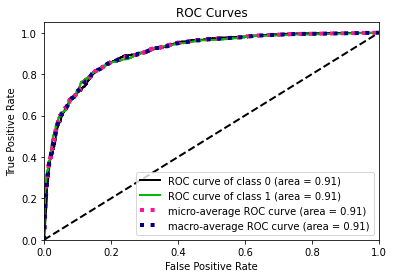

-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1467
           1       0.78      0.82      0.80      1062

    accuracy                           0.83      2529
   macro avg       0.82      0.83      0.83      2529
weighted avg       0.83      0.83      0.83      2529



In [34]:
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='modified_huber', penalty = 'l2', 
                                           alpha=1e-4, max_iter=1000, random_state=3))])
model_SVM = text_clf.fit(x_train, y_train)
predicted = model_SVM.predict(x_test)
stats("SGDC ", model_SVM, x_test, y_test)
print(metrics.classification_report(y_test, predicted))

# Stats on Model

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
def stats(name, model, x_test, y_test):
  # Calculate Accuracy
  prediction = model.predict(x_test)
  acc = np.mean(prediction == y_test)

  # Extract TP, TN, FP, FN
  TN, FP, FN, TP = confusion_matrix(y_test, prediction).ravel()

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)

  # Specificity or true negative rate
  TNR = TN/(TN+FP)

  # Precision
  precision = TP/(TP+FP)

  # F1-Score
  f1 = (2*precision*TPR)/(precision+TPR)

  # Display results
  print(name + ' Accuracy: ' + str(acc))
  print(name + ' True Positive Rate: ' + str(TPR))
  print(name + ' True Negative Rate: ' + str(TNR))
  print(name + ' F1-score: ' + str(f1))
  print('')

  # Display Plot
  # Names of predicted classes
  class_names = ["human", "AI"]

  # Generate the confusion matrix
  cnf_matrix = confusion_matrix(y_test, prediction)

  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title= name + 'Confusion matrix')

  plt.show()

  # Plot ROC Curve
  try:
    y_probas = model.predict_proba(x_test)
    skplt.metrics.plot_roc_curve(y_test, y_probas)
    plt.show()
  except:
    print("ROC can't be generated for " + name)

  print('-----------------------------------------------------')
  print()

Dummy Stratified  Accuracy: 0.4942665085013839
Dummy Stratified  True Positive Rate: 0.3851224105461394
Dummy Stratified  True Negative Rate: 0.5732788002726653
Dummy Stratified  F1-score: 0.39008106819265614

Confusion matrix, without normalization
[[841 626]
 [653 409]]


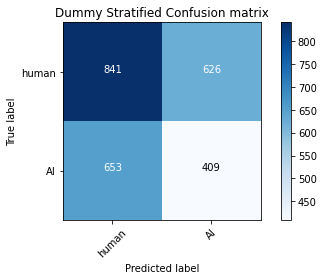

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


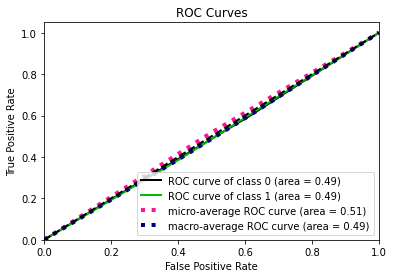

-----------------------------------------------------

Dummy Uniform  Accuracy: 0.4820086990905496
Dummy Uniform  True Positive Rate: 0.4868173258003766
Dummy Uniform  True Negative Rate: 0.4785276073619632
Dummy Uniform  F1-score: 0.4411262798634812

Confusion matrix, without normalization
[[702 765]
 [545 517]]


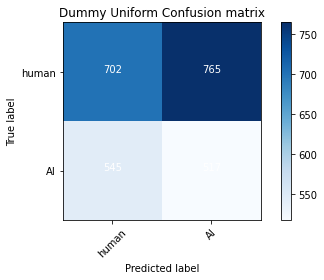

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


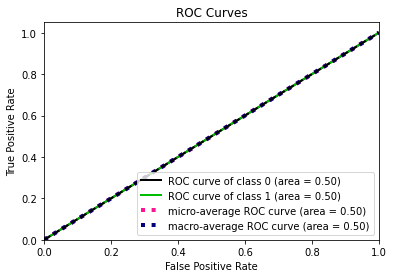

-----------------------------------------------------

Naive Bayes  Accuracy: 0.6852510873863187
Naive Bayes  True Positive Rate: 0.2711864406779661
Naive Bayes  True Negative Rate: 0.9850034083162917
Naive Bayes  F1-score: 0.4198250728862974

Confusion matrix, without normalization
[[1445   22]
 [ 774  288]]


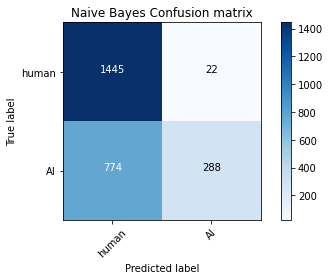

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


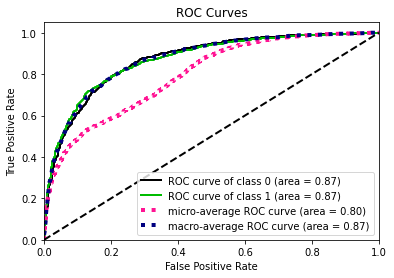

-----------------------------------------------------

SVM  Accuracy: 0.8291814946619217
SVM  True Positive Rate: 0.8239171374764596
SVM  True Negative Rate: 0.8329925017041582
SVM  F1-score: 0.8020164986251146

Confusion matrix, without normalization
[[1222  245]
 [ 187  875]]


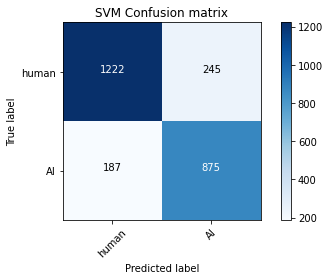

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


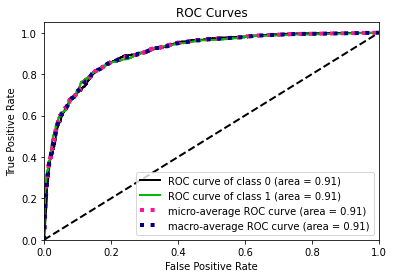

-----------------------------------------------------

Linear SVC  Accuracy: 0.8366943455911428
Linear SVC  True Positive Rate: 0.7975517890772128
Linear SVC  True Negative Rate: 0.8650306748466258
Linear SVC  F1-score: 0.8039867109634552

Confusion matrix, without normalization
[[1269  198]
 [ 215  847]]


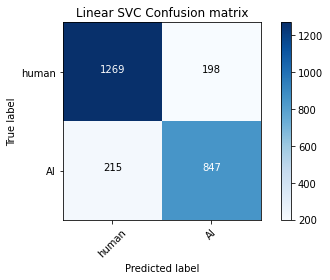

ROC can't be generated for Linear SVC 
-----------------------------------------------------



In [36]:
# Compute Statistics of All Models
stats('Dummy Stratified ', model_dummyStratified, x_test, y_test)
stats('Dummy Uniform ', model_dummyUniform, x_test, y_test)
stats('Naive Bayes ', model_NaiveBayes, x_test, y_test)
stats('SVM ', model_SVM, x_test, y_test)
stats('Linear SVC ', model_linearSVC, x_test, y_test)

In [0]:
input = "Hey my name is Elon Musk. I'm really really really really angry that I have to use my first name. Oh wait, no I'm not. As Elon Musk. I hate myself. A little bit. Also, I just used the wrong form. I'm sorry about that. But one more thing before I start the video. My technical difficulties are caused by my weight and a lack of testosterone. To put it mildly. But I will get over it. My sugar mania is something else. However, that problem is very rare in the Tesla motor industry. Maybe this is what matters most. My thighs are not good for my eyelids so now I've taken a simple method that other people may like. We all make mistakes, I've just learned"

model_SVM.predict([input])

#Save Models

In [0]:
import pickle

# save the model to disk
filename = 'modelSVM.sav'
pickle.dump(model_SVM, open(filename, 'wb'))
 
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(x_test, y_test)
# print(result)

In [0]:
pickle.dump(model_NaiveBayes, open('modelNB.sav', 'wb'))

In [0]:
pickle.dump(model_linearSVC, open('modelLinearSVC.sav', 'wb'))

In [0]:
sgdc = pickle.load(open('modelSVM.sav', 'rb'))
nb = pickle.load(open('modelNB.sav', 'rb'))

In [0]:
model_SVM.score(df_generated_reviews['Review'], df_generated_reviews['Label'])

In [0]:
model_NaiveBayes.score(df_generated_reviews['Review'], df_generated_reviews['Label'])
model_dummyUniform.score(df_generated_reviews['Review'], df_generated_reviews['Label'])
model_dummyStratified.score(df_generated_reviews['Review'], df_generated_reviews['Label'])

In [0]:
model_linearSVC.score(df_generated_reviews['Review'], df_generated_reviews['Label'])